# Mapping loneliness area scores from GP points, Scotland 2022

Takes the df containing loneliness scores for GPs and maps these points to MSOA areas <br>
- Joins GP postcodes to coordinates
- Uses inverse distance weighting to interpolate the loneliness scores for the unknown coordinates between known GP points, implemented through a K-nearest neighbour model
- Zonal statistics per InterZone/MSOA are calculated to get the mean per area using IZ/MSOA polygon shape
- Outputs a csv with loneliness z score, decile and rank per IZ/MSOA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from shapely.geometry import Point
import rasterio as rst
from rasterstats import zonal_stats

# requires installation of geopandas, mapclassify, rasterio, rasterstats

## Join GP postcodes to coordinates

- Get coordinates for postcodes in the UK
- https://geoportal.statistics.gov.uk/datasets/9ac0331178b0435e839f62f41cc61c16

*File needs to be manually downloaded and saved in mapping_data/ folder*

In [2]:
nspl = pd.read_csv("../../extdata/mapping_data/NSPL_MAY_2022_UK.csv", low_memory = False)

In [3]:
nspl.head(5)

,pcd,pcd2,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,osgrdind,oa11,...,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,calncv,stp
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,385386.0,801193.0,1,S00090303,...,3,1C3,57.101474,-2.242851,S99999999,S99999999,S23000009,6715,S99999999,S99999999
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,385177.0,801314.0,1,S00090303,...,3,1C3,57.102554,-2.246308,S99999999,S99999999,S23000009,6715,S99999999,S99999999
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,0,385053.0,801092.0,1,S00090399,...,3,6A1,57.100556,-2.248342,S99999999,S99999999,S23000009,6715,S99999999,S99999999
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,0,384600.0,799300.0,8,S00091322,...,6,1A2,57.084444,-2.255708,S99999999,S99999999,S23000009,5069,S99999999,S99999999
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,1,384460.0,800660.0,8,S00090299,...,3,6A4,57.096656,-2.258102,S99999999,S99999999,S23000009,6253,S99999999,S99999999


In [4]:
nspl = nspl[["pcds", "oseast1m", "osnrth1m", "lsoa11", "msoa11" ]]
nspl["pcds"] = nspl.pcds.str.replace(" ", "")

In [5]:
# Read loneliness scores by GP df created by clincial-scotland-22.ipynb
df = pd.read_csv("../../extdata/scotland_gp_2022.csv")

In [6]:
df.head(2)

,postcode,loneliness_zscore
0,AB101NW,-1.979632
1,AB101QB,7.784077


In [7]:
df.rename(columns = {"postcode":"pcds"}, inplace = True)

In [8]:
df = df.merge(nspl, on = "pcds", how = "left")

In [9]:
df.isna().value_counts()

pcds   loneliness_zscore  oseast1m  osnrth1m  lsoa11  msoa11
False  False              False     False     False   False     739
Name: count, dtype: int64

In [10]:
df.head(2)

,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11
0,AB101NW,-1.979632,392709.0,805764.0,S01006571,S02001247
1,AB101QB,7.784077,393104.0,805894.0,S01006571,S02001247


## Read DF as Geopanda

In [11]:
# CRS =  EPSG 27700, reads gpd as British National Grid coords
# Create a new col 'geometry'

geo_data = gpd.GeoDataFrame(data = df, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = df.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

C:\Users\JennaTan\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,pcds,loneliness_zscore,oseast1m,osnrth1m,lsoa11,msoa11,geometry
0,AB101NW,-1.979632,392709.0,805764.0,S01006571,S02001247,POINT (392709.000 805764.000)
1,AB101QB,7.784077,393104.0,805894.0,S01006571,S02001247,POINT (393104.000 805894.000)
2,AB101UT,2.910320,393051.0,806083.0,S01006584,S02001249,POINT (393051.000 806083.000)
3,AB101YE,1.199900,393170.0,805747.0,S01006571,S02001247,POINT (393170.000 805747.000)
4,AB107QQ,-1.607957,391998.0,803177.0,S01006528,S02001239,POINT (391998.000 803177.000)


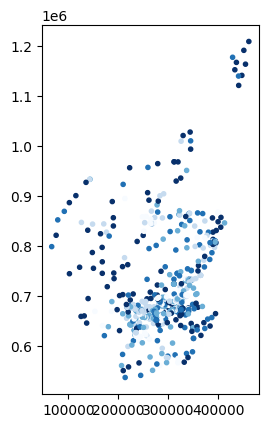

In [12]:
# Visualise loneliness score geographically using geometry col
geo_data.plot(column = 'loneliness_zscore', scheme = 'quantiles', cmap = 'Blues', marker = '.');

- Points somewhat evenly distriubted across Scotland
- With clusters around cities
- Lighter dots indicate lower levels of loneliness - expect to see that pattern replicated in final output

## Develop KNN model and predict unknown coordinates

### Instantiate KNN as inverse distance weighted model 

In [13]:
def idw_model(k, p):
    """
    Instantiates a KNN regressor as an IDW interpolater. k = no. neighbours, p = power for idw
    """
    def _inv_distance_index(weights, index=p):
        """Weights set as distance from the input points and neighbour, with an inverse calculation of (1/dist**power).
        Values not dividable by 0 are ignored.
        """
        #return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
        
        with np.errstate(divide='ignore', invalid='ignore'):
            safe_weights = 1. / weights**index
        return np.nan_to_num(safe_weights, posinf=0) # ignore weights that are negative
        
    return KNeighborsRegressor(k, weights=_inv_distance_index)

<span style="color: blue;"> NOTE: See the original code commented out above. Was unsure what *test* was so I've replaced with the above function.  </span>


<span style="color: blue;"> NOTE: You'll see in the sections below that the input data points (i.e. the coordinates of GPs) are not removed from the estimation grid --> data leakage!!!. However I think because this function is set to ignore distances that are 0 it cancels out the input points, as points with 0 distance from the known data is the input data.  </span>

### Train test split

<span style="color: blue;"> NOTE: I added these sections below to find the best hyper params and to test the KNN model with a test dataset. </span>

In [14]:
# Get existing point locations and values to fit the model
points = geo_data[['oseast1m','osnrth1m']].values
vals = geo_data['loneliness_zscore'].values

In [15]:
len(vals)

739

In [16]:
X_train, X_test, y_train, y_test = train_test_split(points, vals, test_size=0.2, random_state=42)

### Find best k and p values

In [17]:
param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20],
    'p': [1, 1.5, 2, 2.5, 3]
}

knn_model = idw_model(1,1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(knn_model, param_grid, cv=kf)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(n_neighbors=1,
                                           weights=<function idw_model.<locals>._inv_distance_index at 0x00000204BBC69550>),
             param_grid={'n_neighbors': [3, 5, 10, 15, 20],
                         'p': [1, 1.5, 2, 2.5, 3]})

In [18]:
best_k = grid_search.best_params_['n_neighbors']
best_p = grid_search.best_params_['p']

print("Best k:", best_k)
print("Best p:", best_p)

Best k: 20
Best p: 1


<span style="color: blue;"> NOTE: Best k is suspciously high. In the original code k was set at 5 (which is the default for the model) and p at 2 (default for inverse distance weighting). </span>

In [19]:
grid = idw_model(20,1).fit(X_train, y_train)
original = idw_model(5,2).fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)
y_pred_original = original.predict(X_test)

In [20]:
print(f" Grid Search MSE: {mean_squared_error(y_test, y_pred_grid)}")
print(f" Original params MSE: {mean_squared_error(y_test, y_pred_original)}")

 Grid Search MSE: 6.564168666239064
 Original params MSE: 7.140840336442085


<span style="color: blue;"> NOTE: MSE is better with k = 20 and p = 1...... However is this the right test? It implies an inverse distance relationship across GP surgeries i.e. that there is clustering in loneliness levels across GPs  </span>

### Use best params to fit model

In [21]:
idw = idw_model(20, 1).fit(points, vals)

### Create grid of unknown values to predict

In [22]:
# Get minimum and maximum coords from the data
print("xmin = ", geo_data['oseast1m'].min(), "\n\r",
      "xmax = ", geo_data['oseast1m'].max(), "\n\r",
      "ymin = ", geo_data['osnrth1m'].min(), "\n\r",
      "ymax = ", geo_data['osnrth1m'].max())

xmin =  66531.0 
 xmax =  461080.0 
 ymin =  536471.0 
 ymax =  1208925.0


In [23]:
xmin = 66000
xmax = 462000
ymin = 536000
ymax = 1210000

In [24]:
def grid(xmin, xmax, ymin, ymax, cellsize):
    """
    Creates an evenly spaced grid structure of all possible x and y coords within the bounds of the data that will be 
    used for prediction. Even spacing ensures reliable and uniform coverage of the surface for estimation.
    
    """
    # Adjust x and y ranges to be perfectly divisible by cellsize using floor and ceiling division, ensuring even spacing
    xmin = (xmin // cellsize) * cellsize 
    xmax = -(-xmax // cellsize) * cellsize 
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    
    # Generate coords within adjusted min/max range with regular spacing determined by cellsize
    x = np.linspace(xmin,xmax,int((xmax-xmin)/cellsize))
    y = np.linspace(ymin,ymax,int((ymax-ymin)/cellsize))
    
    # Create grid structure of all possible x and y points, returns two 2D arrays
    xx,yy = np.meshgrid(x,y)
   
    return xx, yy

In [25]:
xx,yy = grid(xmin, xmax, ymin, ymax, 250 )

<span style="color: blue;"> NOTE: Cellsize of 250 is hardcoded in the original code. Not sure how that number is determined. </span>

In [26]:
def reshape_grid(xx,yy):
    """ 
    Reshape output of the meshgrid into a single array combining x and y coords.
    Ravel flattens xx/yy into (1,n) and [] turns it into a col vector (n,1). 
    Two col vectors combined to form xy
    """
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

In [27]:
xy = reshape_grid(xx,yy)

### Predict unknown values using trained KNN model

In [28]:
# Predict values in the grid. Returns 1D array, (n,1)
scores = idw.predict(xy)

In [29]:
scores.shape

(4270464,)

### Reshape prediction to grid

- KNN Regresor outputs a 1D array - predictions per coordinate
- It needs to be reshaped to 2D to allign with the xx,yy meshgrid

In [30]:
def reshape_image(scores, xx):
    return np.flip(scores.reshape(np.shape(xx)),0)

scores = reshape_image(scores, xx)

In [31]:
scores.shape == xx.shape

True

In [32]:
scores.shape

(2696, 1584)

<span style="color: blue;"> NOTE: If we assume that data leakage hasn't happened because input data points are ignored then does that mean the input data points need to be put back in? </span>

### Inspect surface outcome

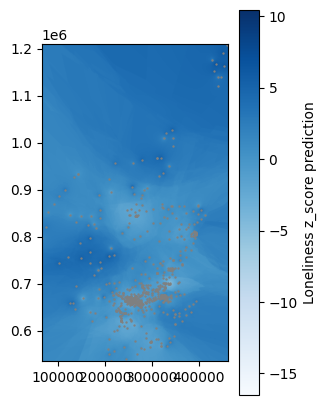

In [33]:
f, ax = plt.subplots(figsize = (3,5))
#ax.imshow(z, cmap='Reds')
#ax.set_aspect('equal')

heatmap = ax.imshow(scores, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax.scatter(points[:, 0], points[:, 1], color='grey', s=0.5)
cbar = plt.colorbar(heatmap, ax=ax, label='Loneliness z_score prediction')


- Roughly matches expectation of a lighter colour, indicating lower loneliness ratings, around clusters

## Map values to InterZone (MSOA)

- Get the Intermediate Zone shape files from https://www.data.gov.uk/dataset/133d4983-c57d-4ded-bc59-390c962ea280/intermediate-zone-boundaries-2011
- Get zonal stats per IZ based on predictions

*The zip folder needs to be manually downloaded and saved in extdata/mapping_data/boundary*

In [34]:
# Get MSOAs which we use to aggregate the z score variable.
filestring = r'../../extdata/mapping_data/boundary/SG_IntermediateZone_Bdry_2011.shp'

msoas = gpd.read_file(filestring)
msoas.to_crs({'init':'epsg:27700'}).head(5) # projects coordinates onto British National Grid

C:\Users\JennaTan\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,InterZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaKm2,StdAreaHa,geometry
0,S02001236,Culter,4845,4733,2143,19.553709,1955.371256,"POLYGON ((379360.200 804845.000, 379373.900 80..."
1,S02001237,"Cults, Bieldside and Milltimber West",4007,3751,1428,19.758838,1975.883716,"POLYGON ((383981.182 806104.601, 383973.868 80..."
2,S02001238,"Cults, Bieldside and Milltimber East",6112,5850,2291,5.275116,527.511832,"POLYGON ((389550.557 803884.610, 389581.784 80..."
3,S02001239,Garthdee,5229,5152,2439,1.493716,149.371708,"POLYGON ((392626.000 804064.000, 392632.000 80..."
4,S02001240,"Braeside, Mannofield, Broomhill and Seafield East",4419,4358,2193,0.837722,83.772094,"POLYGON ((393251.008 805451.033, 393249.774 80..."


In [35]:
# Affine transformation maps pixels from the KNN estimates to spatial coordinates of each MSOA's geometry
# 250 = pixels resolution (size of each pixel in x/y direction)
# 125 = spatial alignment in x/y direction

trans = rst.Affine.from_gdal(xmin-125,250,0,ymax+125,0,-250)

<span style="color: blue;"> NOTE: The values 250 and 125 are harcoded above. Not sure how they are determined. Noteably a cellsize was also hardcoded as 250. </span>

In [36]:
# Get the mean predicted score based on MSOA polygon shape, returns a dictionary
msoa_zones = zonal_stats(msoas['geometry'], scores, affine = trans, stats = 'mean', nodata = np.nan)

In [37]:
# Extract score from dictionary, turn into a list and add as col in .shp
msoas['loneliness_zscore'] = list(map(lambda x: x['mean'] , msoa_zones))

<Axes: >

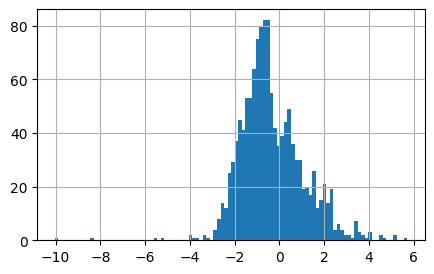

In [38]:
msoas['loneliness_zscore'].hist(bins = 100, figsize = (5,3))

In [39]:
msoas["rank"] = msoas["loneliness_zscore"].rank()
msoas["deciles"] = pd.qcut(msoas["loneliness_zscore"], q=10, labels=False)

C:\Users\JennaTan\AppData\Local\Temp\ipykernel_11416\1621668677.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu', len(decile_values))


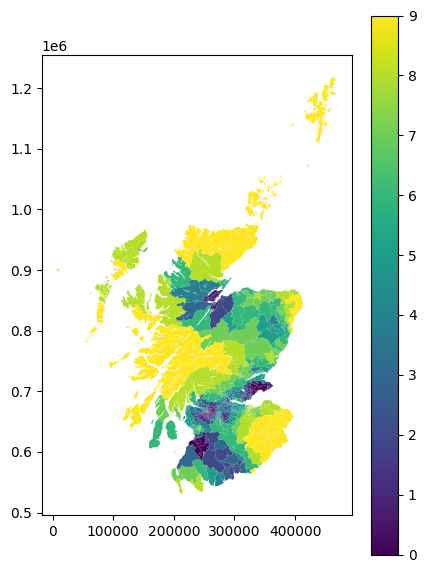

In [40]:
from matplotlib.patches import Patch
import matplotlib.cm as cm

decile_values = msoas['deciles'].unique()

# Automatically generate colors based on the number of unique decile values
cmap = cm.get_cmap('RdYlBu', len(decile_values))

# Create the legend handles for each decile range
handles = []
for i, decile in enumerate(decile_values):
    col = cmap(i)
    handles.append(Patch(facecolor=col, label=f"Decile {decile}"))

# Create the plot of Scotland map with the decile colors
fig, ax = plt.subplots(figsize=(5, 7))
msoas.plot(column='deciles', ax=ax, legend=True);


- Above average scores of loneliness appear associated with rural areas; below average scores with denser areas. 
- However is this to do with the geographic size of MSOAs?


This appears very roughly in line with the visual created from original code, see image:
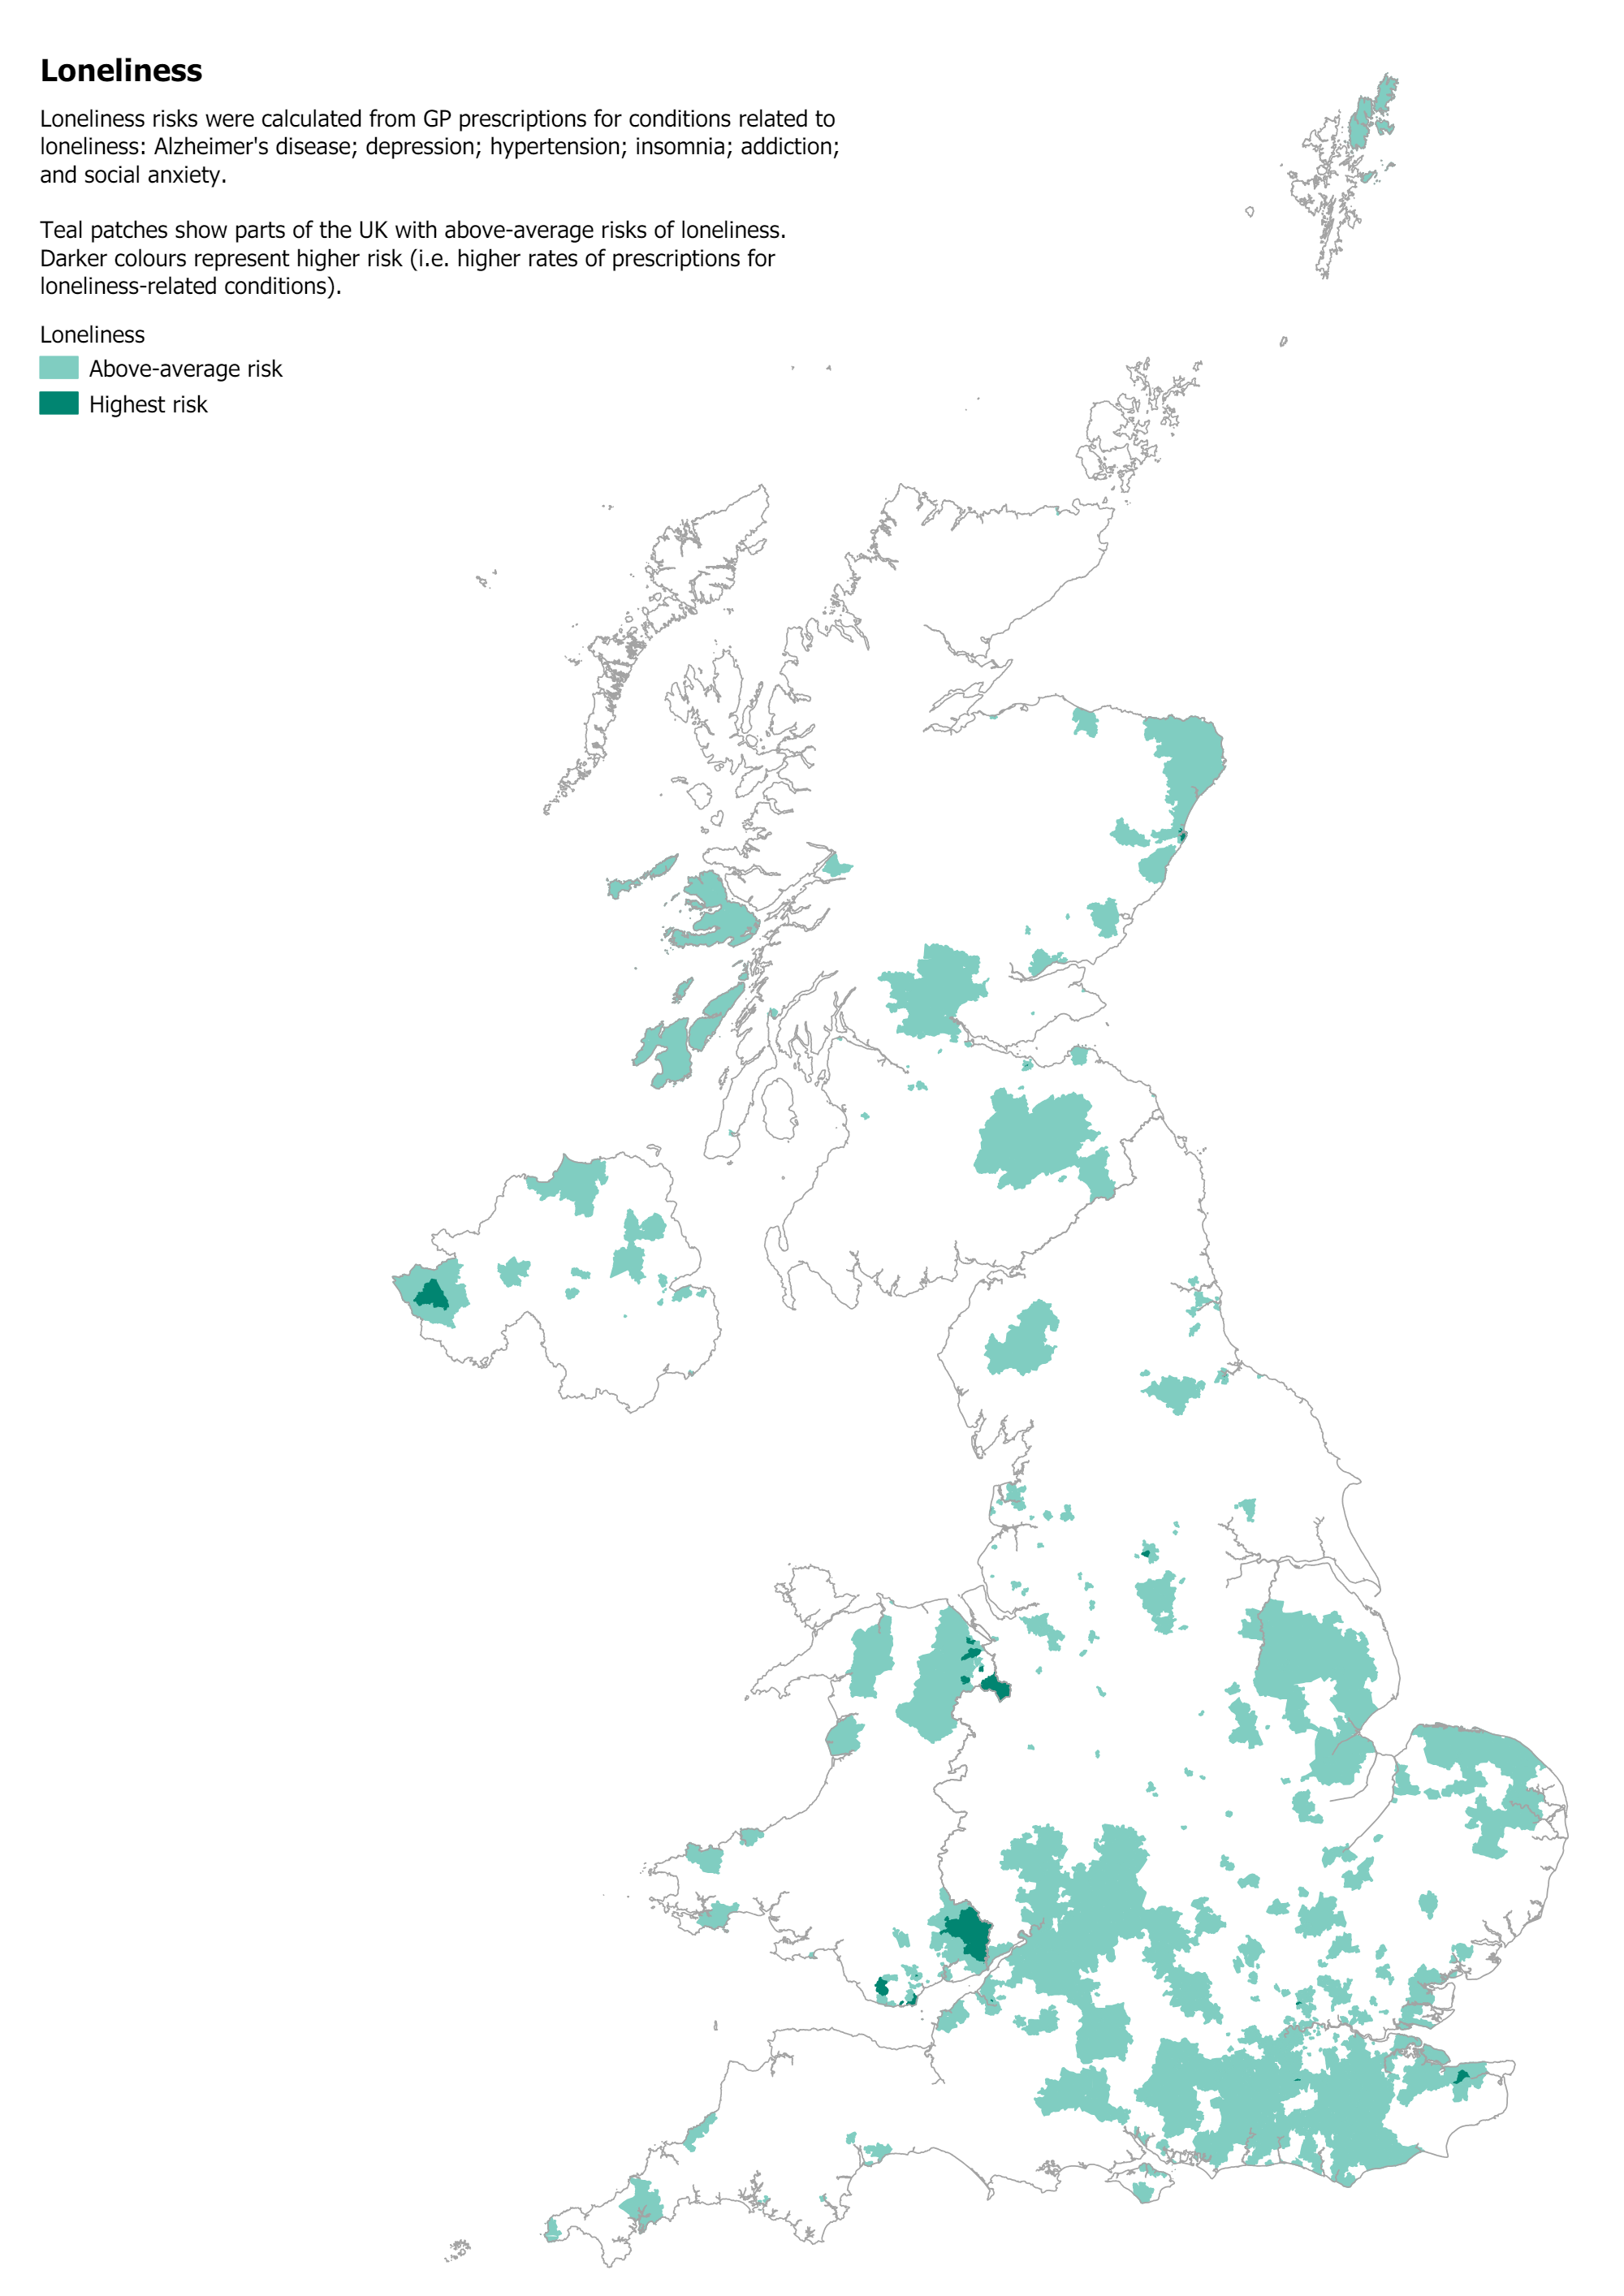



In [41]:
msoas = msoas[['InterZone', 'loneliness_zscore','rank','deciles']]
msoas.rename(columns = {'InterZone':'iz11_code'}, inplace = True)

C:\Users\JennaTan\AppData\Local\Temp\ipykernel_11416\2885823872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msoas.rename(columns = {'InterZone':'iz11_code'}, inplace = True)


In [42]:
msoas.describe()

,loneliness_zscore,rank,deciles
count,1279.000000,1279.000000,1279.000000
mean,-0.344766,640.000000,4.499609
std,1.422458,369.359807,2.874494
min,-10.026416,1.000000,0.000000
25%,-1.246132,320.500000,2.000000
50%,-0.576384,640.000000,4.000000
75%,0.451526,959.500000,7.000000
max,5.713890,1279.000000,9.000000


In [43]:
msoas.to_csv("../../extdata/scotland_iz_2022.csv", index = False)